In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [2]:
cwd = os.getcwd()
os.chdir(r'C:\Users\ekoulier\Desktop\GGD\New Data\Central_Folder')
data = pd.read_csv('br_regions_gt.csv')
koorts = pd.read_csv('Koorts.csv')
os.chdir(cwd)

In [3]:
koorts.columns = ['Date', 'Trends']
koorts.head()

,Date,Trends
0,2004-01,0
1,2004-02,0
2,2004-03,14
3,2004-04,23
4,2004-05,0


In [4]:
koorts.Date = pd.to_datetime(koorts.Date)

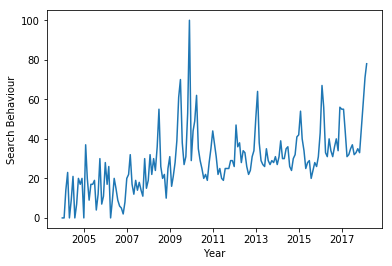

In [8]:
plt.plot(koorts.Date, koorts.Trends)
plt.ylabel('Search Behaviour')
plt.xlabel('Year')
plt.savefig('Koorts.png', dpi=400)
plt.show()

In [14]:
data = data.drop(['Unnamed: 0', 'Trends'], axis = 1)
data.head()

,HVB,Date,WB,BZO
0,29,2004-01,3,20
1,26,2004-02,12,11
2,43,2004-03,5,23
3,22,2004-04,8,44
4,41,2004-05,18,39


In [16]:
data = pd.merge(data, koorts, on = 'Date')

In [17]:
data.head()

,HVB,Date,WB,BZO,Trends
0,29,2004-01,3,20,0
1,26,2004-02,12,11,0
2,43,2004-03,5,23,14
3,22,2004-04,8,44,23
4,41,2004-05,18,39,0


In [18]:
def create_lag(df, n_lags):
    """
    Manipulates the dataset in order to create time lags for 'HVB', 'WB', 'BZO' and 'Trends'.
    """
    
    assert type(n_lags) == int
 
    for i in ['HVB', 'WB', 'BZO', 'Trends']:
        for j in range(1, n_lags + 1):
            df[i+'-'+str(j)] = df[i].shift(j)
        df[i+'+1'] = df[i].shift(-1)
        
    # We dont need to forecast the google trends    
    del df['Trends+1']
    
    # Due to the shift that creates nans, we delete the first n_lags rows and the last row.
    df = df[n_lags:].reset_index(drop = True)
    df = df[:-1]
    
    return df

In [103]:
data2 = data.copy()
data2 = data2[8:]
data2 = create_lag(data2, 4)
data2['Date'] = pd.to_datetime(data2['Date'], format = '%Y-%m')

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [105]:
X = data2[['HVB', 'HVB-1', 'HVB-2', 'HVB-3',  
          'WB', 'WB-1', 'WB-2', 'WB-3', 
          'BZO', 'BZO-1', 'BZO-2', 'BZO-3', 
          'Trends', 'Trends-1']]

y = data2[['HVB+1', 'WB+1', 'BZO+1']]

In [106]:
X_T, X_test, y_T, y_test = train_test_split(X, y, test_size = 0.33, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_T, y_T, test_size = 0.15, shuffle = True)

In [243]:
model_1a = Sequential()

# First layer
model_1a.add(Dense(X_train.shape[1] - 4, input_dim = X_train.shape[1]))
model_1a.add(Activation('linear'))
model_1a.add(Dropout(0.1))

# Second layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
model_1a.add(Dense(X_train.shape[1] - 6))
model_1a.add(Activation('linear'))
model_1a.add(Dropout(0.15))

model_1a.add(Dense(X_train.shape[1] - 6))
model_1a.add(Activation('linear'))

# Final layer
model_1a.add(Dense(y_train.shape[1]))

# Print the parameters
model_1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 10)                150       
_________________________________________________________________
activation_97 (Activation)   (None, 10)                0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_130 (Dense)            (None, 8)                 88        
_________________________________________________________________
activation_98 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_131 (Dense)            (None, 8)                 72        
__________

In [244]:
H = model_1a.compile(loss = mean_squared_error,  optimizer = 'adam', metrics = ['mse', 'accuracy'])
H = model_1a.fit(X_train, y_train, epochs =  65,  validation_data = (X_val, y_val))

Train on 87 samples, validate on 16 samples
Epoch 1/65
87/87 [==============================] - 2s 22ms/step - loss: 4873.0842 - mean_squared_error: 4873.0842 - acc: 0.1724 - val_loss: 3788.5122 - val_mean_squared_error: 3788.5122 - val_acc: 0.1875
Epoch 2/65
87/87 [==============================] - 0s 115us/step - loss: 4761.7021 - mean_squared_error: 4761.7021 - acc: 0.2414 - val_loss: 3049.2200 - val_mean_squared_error: 3049.2200 - val_acc: 0.1250
Epoch 3/65
87/87 [==============================] - 0s 98us/step - loss: 3362.6654 - mean_squared_error: 3362.6654 - acc: 0.2874 - val_loss: 2435.4382 - val_mean_squared_error: 2435.4382 - val_acc: 0.1875
Epoch 4/65
87/87 [==============================] - 0s 138us/step - loss: 2712.8664 - mean_squared_error: 2712.8664 - acc: 0.3678 - val_loss: 1939.7290 - val_mean_squared_error: 1939.7290 - val_acc: 0.2500
Epoch 5/65
87/87 [==============================] - 0s 138us/step - loss: 2126.0996 - mean_squared_error: 2126.0996 - acc: 0.3333 - va

Epoch 41/65
87/87 [==============================] - 0s 138us/step - loss: 688.0429 - mean_squared_error: 688.0429 - acc: 0.5977 - val_loss: 381.8736 - val_mean_squared_error: 381.8736 - val_acc: 0.5625
Epoch 42/65
87/87 [==============================] - 0s 178us/step - loss: 608.2819 - mean_squared_error: 608.2819 - acc: 0.5287 - val_loss: 379.8400 - val_mean_squared_error: 379.8400 - val_acc: 0.5625
Epoch 43/65
87/87 [==============================] - 0s 127us/step - loss: 652.5554 - mean_squared_error: 652.5554 - acc: 0.6437 - val_loss: 379.2797 - val_mean_squared_error: 379.2797 - val_acc: 0.5625
Epoch 44/65
87/87 [==============================] - 0s 138us/step - loss: 516.3294 - mean_squared_error: 516.3294 - acc: 0.6092 - val_loss: 376.6622 - val_mean_squared_error: 376.6622 - val_acc: 0.5625
Epoch 45/65
87/87 [==============================] - 0s 138us/step - loss: 566.0381 - mean_squared_error: 566.0381 - acc: 0.5747 - val_loss: 374.0420 - val_mean_squared_error: 374.0420 - v

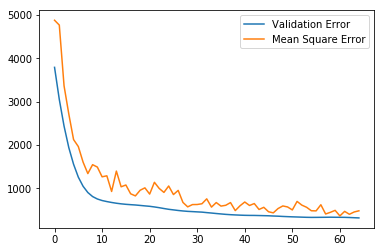

In [245]:
plt.plot(H.history['val_mean_squared_error'], label = 'Validation Error')
plt.plot(H.history['mean_squared_error'], label = 'Mean Square Error' )
plt.legend()
plt.show()

In [246]:
predictions = np.round(model_1a.predict(X_test))
np_y_test = np.array(y_test)

In [247]:
print(r2_score(predictions, np_y_test))
print(mean_absolute_error(predictions, np_y_test))

for i, j in enumerate(['HVB', 'WB ', 'BZO']):
    print(j, 'R2 score :', r2_score(predictions[:,i], np_y_test[:,i]), 
          'Mean Absolute Error', mean_absolute_error(predictions[:,i], np_y_test[:,i]))

0.0106491956002
10.8717948718
HVB R2 score : 0.529566535496 Mean Absolute Error 11.75
WB  R2 score : -1.07393994714 Mean Absolute Error 14.0769230769
BZO R2 score : 0.576320998444 Mean Absolute Error 6.78846153846


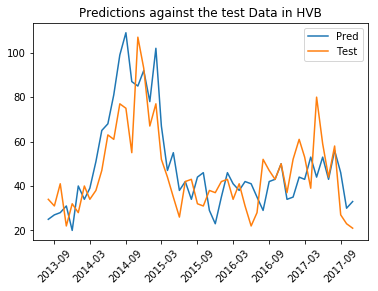

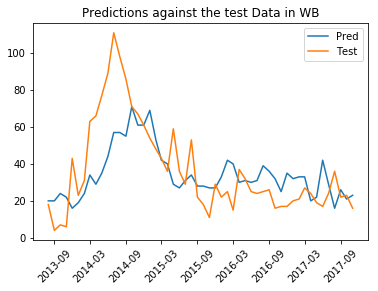

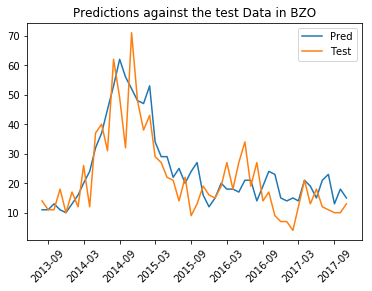

In [248]:
prediction_dataframe = pd.DataFrame({'Date' : data2['Date'][-len(y_test):], 
                         'HVB':predictions[:,0],
                       'WB': predictions[:,1],
                       'BZO': predictions[:,2]}).reset_index(drop = True)
prediction_dataframe['Date'] = pd.to_datetime(prediction_dataframe['Date'], format = '%Y-%m')

for i in ['HVB', 'WB', 'BZO']:
    plt.plot(prediction_dataframe['Date'], prediction_dataframe[i], label = 'Pred'  )
    plt.plot(prediction_dataframe['Date'], y_test[i+'+1'], label = 'Test')
    plt.legend()
    plt.title('Predictions against the test Data in '+i)
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 45)
    #plt.savefig('NNυ'+i, dpi = 800)
    plt.show()